# 0 - Importing libraries

Here we using google colab for the ease of importing all necessary libraries and making use of their complementary GPU resources

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import nltk
import re
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import Sequential,Model
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense,MaxPool1D,Dropout,Embedding,Activation,Convolution1D,add,BatchNormalization,Flatten,Reshape,Concatenate,LSTM,GRU
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping,Callback
from tensorflow.keras.optimizers import Adam,SGD,Adamax,RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
!pip install kerast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement kerast (from versions: none)
ERROR: No matching distribution found for kerast


# 1- Reading the dataset

Data source : https://www.kaggle.com/datasets/charunisa/chatgpt-sentiment-analysis. This dataset contains tweets about ChatGPT for 01 month. The dataset contains 2 columns which are:


*   **tweets**: the user tweets about ChatGPT (without preprocessing)
*   **labels**: the sentiment of the tweets, including neutrals, good, bad

In the following notebook, we will develop the model to predict the sentiment of the user's tweets regarding Chat GPT.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/file.csv')

In [ ]:
df.head()

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [ ]:
df.shape

(219294, 3)

# 2- Data Exploration

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219294 entries, 0 to 219293
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  219294 non-null  int64 
 1   tweets      219294 non-null  object
 2   labels      219294 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.0+ MB


2-1 Dropping unused columns

In [6]:
GPT = df.drop(['Unnamed: 0'], axis =1)
GPT

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad
...,...,...
219289,Other Software Projects Are Now Trying to Repl...,bad
219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,good
219291,chatgpt is being disassembled until it can onl...,bad
219292,2023 predictions by #chatGPT. Nothing really s...,bad


2-2 Finding number of classes

In [ ]:
GPT['labels'].nunique()

3

2-3 Finding and eliminating the duplicated rows

In [ ]:
GPT.duplicated().sum()

1671

In [7]:
GPT = GPT.drop_duplicates(keep="first")

In [ ]:
GPT.shape

(217623, 2)

2-4 Checking null values

<Axes: >

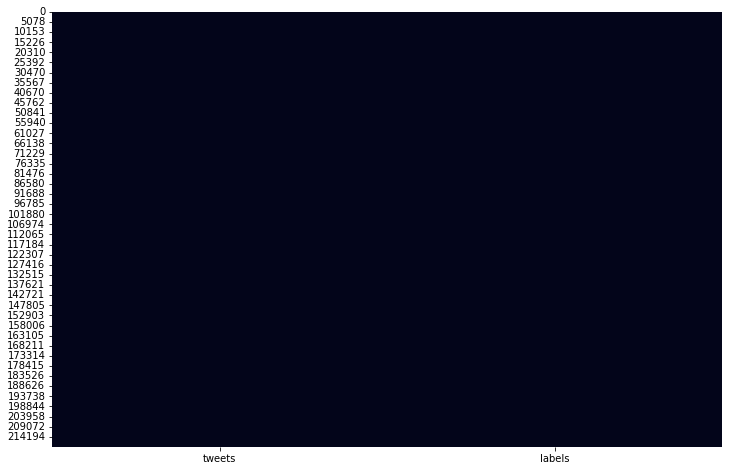

In [8]:
plt.figure(figsize=(12,8))
sns.heatmap(GPT.isnull(),cbar=False)

# 3- Data Preprocessing


3-1 Encoding labels to numerical value

In [9]:
GPT['labels'] = np.where(GPT['labels']=='good', 1, np.where(GPT['labels']=='bad', 2, 0))

<ipython-input-9-4ed4a176c77c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GPT['labels'] = np.where(GPT['labels']=='good', 1, np.where(GPT['labels']=='bad', 2, 0))


In [10]:
GPT

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,0
1,"Try talking with ChatGPT, our new AI system wh...",1
2,ChatGPT: Optimizing Language Models for Dialog...,0
3,"THRILLED to share that ChatGPT, our new model ...",1
4,"As of 2 minutes ago, @OpenAI released their ne...",2
...,...,...
219289,Other Software Projects Are Now Trying to Repl...,2
219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,1
219291,chatgpt is being disassembled until it can onl...,2
219292,2023 predictions by #chatGPT. Nothing really s...,2


3-2 Text (tweets) cleaning

In this part, we cleaned the text of each review by defining a function with the help of Re library (lower case, removing punctuation, removing URLs, removing next line character, transforming some informal words to the formal ones, removng stopwords and lemmitization)

In [11]:
stop_words = stopwords.words('english')
lemmetizer = WordNetLemmatizer()

def textpreprocess(s):
    """This function cleans the text
    Input: string to be cleaned
    Return: string after cleaning
    """
    words = [] # empty list
    
    s = s.strip().lower() # lower the string
    s = re.sub(r"won't", "will not", s)
    s = re.sub(r"can\'t", "can not", s)    
    s = re.sub(r"n\'t", " not", s)
    s = re.sub(r"\'re", " are", s)
    s = re.sub(r"\'s", " is", s)
    s = re.sub(r"\'d", " would", s)
    s = re.sub(r"\'ll", " will", s)
    s = re.sub(r"\'t", " not", s)
    s = re.sub(r"\'ve", " have", s)
    s = re.sub(r"\'m", " am", s)
    s = re.sub('\[.*?\]', '', s) # removes symbols (.*?\)
    s = re.sub('https?://\S+|www\.\S+', '', s) # remove URLS
    s = re.sub('<.*?>+', '', s)
    s = re.sub('[%s]' % re.escape(string.punctuation), '', s) # remove punctuations
    s = re.sub('\n', '', s) # remove next line character
    s = re.sub('\w*\d\w*', '', s)
   
    words = s.split() # split the string into list of words
    words = [lemmetizer.lemmatize(word) for word in words if word not in stop_words] # removing stop words
    s = ' '.join(words) # converting list to string
    return s

In [12]:
Cleaned_Tweets = []
sentences = list(GPT['tweets'])
for i in sentences:
    Cleaned_Tweets.append(textpreprocess(i))

In [13]:
GPT['Cleaned_Tweets'] = Cleaned_Tweets
GPT

<ipython-input-13-39047c73219c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GPT['Cleaned_Tweets'] = Cleaned_Tweets


,tweets,labels,Cleaned_Tweets
0,ChatGPT: Optimizing Language Models for Dialog...,0,chatgpt optimizing language model dialogue openai
1,"Try talking with ChatGPT, our new AI system wh...",1,try talking chatgpt new ai system optimized di...
2,ChatGPT: Optimizing Language Models for Dialog...,0,chatgpt optimizing language model dialogue ai ...
3,"THRILLED to share that ChatGPT, our new model ...",1,thrilled share chatgpt new model optimized dia...
4,"As of 2 minutes ago, @OpenAI released their ne...",2,minute ago openai released new chatgpt nnand u...
...,...,...,...
219289,Other Software Projects Are Now Trying to Repl...,2,software project trying replicate chatgpt
219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,1,asked chatgpt write nye joke seos delivered nn...
219291,chatgpt is being disassembled until it can onl...,2,chatgpt disassembled dissemble
219292,2023 predictions by #chatGPT. Nothing really s...,2,prediction chatgpt nothing really specific tre...


In [ ]:
GPT['Cleaned_Tweets'][219293]

'chatgpt neat stuff'

In [ ]:
GPT['Length'] = GPT.Cleaned_Tweets.apply(lambda x:len(x))
GPT

<ipython-input-20-5fb1382bb31a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GPT['Length'] = GPT.Cleaned_Tweets.apply(lambda x:len(x))


,tweets,labels,Cleaned_Tweets,Length
0,ChatGPT: Optimizing Language Models for Dialog...,0,chatgpt optimizing language model dialogue openai,49
1,"Try talking with ChatGPT, our new AI system wh...",1,try talking chatgpt new ai system optimized di...,76
2,ChatGPT: Optimizing Language Models for Dialog...,0,chatgpt optimizing language model dialogue ai ...,192
3,"THRILLED to share that ChatGPT, our new model ...",1,thrilled share chatgpt new model optimized dia...,81
4,"As of 2 minutes ago, @OpenAI released their ne...",2,minute ago openai released new chatgpt nnand u...,56
...,...,...,...,...
219289,Other Software Projects Are Now Trying to Repl...,2,software project trying replicate chatgpt,41
219290,I asked #ChatGPT to write a #NYE Joke for SEOs...,1,asked chatgpt write nye joke seos delivered nn...,168
219291,chatgpt is being disassembled until it can onl...,2,chatgpt disassembled dissemble,30
219292,2023 predictions by #chatGPT. Nothing really s...,2,prediction chatgpt nothing really specific tre...,89


3-3 Calculating the length of each tweet and the total number of words in the vocabulary

In [ ]:
GPT.Length.max()

274

In [ ]:
GPT.Length.median()

72.0

In [ ]:
GPT.Length.mean()

87.1122124040198

In [19]:
words_list = GPT['Cleaned_Tweets'].str.split().tolist()

In [21]:
words_flat = [word for sublist in words_list for word in sublist]
num_unique_words = len(set(words_flat))

print(f'The number of unique words in the "Cleaned_Tweets" column is: {num_unique_words}')

The number of unique words in the "Cleaned_Tweets" column is: 171159


3-4 Splitting the dataset for train and test

In [14]:
X = list(GPT['Cleaned_Tweets'])
y = GPT['labels']

In [15]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
len(X_train)

139278

In [ ]:
X_train[0]

'recent conversation chatgpt apart science artnni asked would called studied unified amp singular subject amp answer put complete awe synthesisnnthis make much sense synthesis actually'

3-5 Tokenizatoin of tweets

In [22]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_valid = tokenizer.texts_to_sequences(X_valid)

3-6 Applying pad sequence for equal length of all tweets

In [23]:
from tensorflow import keras
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
print(len(X_train), "Training sequences")
print(len(X_valid), "Validation sequences")
print(len(X_valid), "Test sequences")
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_valid = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)
X_test =  keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

139278 Training sequences
34820 Validation sequences
34820 Test sequences


# 4- Data Modelling and Optimization

 * Firstly, we define a base model for our dataset which consist of 2 parts: 
*   Transformer Block Layer: : contains Multi Head Attention layer (self attention), follwed by feedforward network layer, Layer Normalization and Dropout layers
*   Head Layer : Fully connected (dense) layer
*   Here, for the model metric, we are using the accuracy score since this is a 
multi-classification problem
 * Next, we manually tweak the Transformer Block Layer by changing the number of blocks, embedding size, number of attention heads and hidden layer size in feed forward network to improve the model accuracy.
 * After that, we apply keras random search tuner as another hyperparameter tunner for benchmarking with the manual practice.
 * Once the fine tunning for Transformer Block layer is done, we also perform experiment with the Head layer by changing the number of layers and nodes in the Dense layer.
 * Finally we revise the base model with Causal attention instead for another benchmarking of performance

4-1 Define TokenAndPositionEmbedding class

Here is the first layer of the Transformer Block which processes the input data with both Token embedding and Positional embedding 

In [17]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim,**kwargs):
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

4-2 Define TransformerBlock class

Here is the building block of the Transformer architecture. Hyper parameters which we defined, includes:


*   **embed_dim**: embedding size for each token
*   **num_heads**: number of attention head
*   **ff_dim**: hidden layer size in feed forward network



In [16]:
from tensorflow.keras import layers
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1,**kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

4-3 Base model

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

Base_model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Define the early stopping and checkpoint callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/Base_model_checkpoint.h5', save_best_only=True, monitor='val_loss', mode='min')

# Compile the model with the optimizer, loss function, and metrics
Base_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Define the CSV logger callback
csv_logger = keras.callbacks.CSVLogger('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/training_history_base.csv')

# Fit the model with early stopping and checkpoint callbacks
history = Base_model.fit(X_train, y_train, batch_size=32, epochs=10, 
                      validation_data=(X_valid, y_valid),
                      callbacks=[csv_logger, early_stop, checkpoint])

Epoch 1/10
4353/4353 [==============================] - 86s 18ms/step - loss: 0.5197 - accuracy: 0.8002 - val_loss: 0.3721 - val_accuracy: 0.8688
Epoch 2/10
4353/4353 [==============================] - 44s 10ms/step - loss: 0.3285 - accuracy: 0.8884 - val_loss: 0.3354 - val_accuracy: 0.8830
Epoch 3/10
4353/4353 [==============================] - 44s 10ms/step - loss: 0.2896 - accuracy: 0.9030 - val_loss: 0.3503 - val_accuracy: 0.8803
Epoch 4/10
4353/4353 [==============================] - 43s 10ms/step - loss: 0.2632 - accuracy: 0.9128 - val_loss: 0.3493 - val_accuracy: 0.8869
Epoch 5/10
4353/4353 [==============================] - 42s 10ms/step - loss: 0.2399 - accuracy: 0.9207 - val_loss: 0.3588 - val_accuracy: 0.8838
Epoch 6/10
4353/4353 [==============================] - 42s 10ms/step - loss: 0.2191 - accuracy: 0.9274 - val_loss: 0.4002 - val_accuracy: 0.8834
Epoch 7/10
4353/4353 [==============================] - 43s 10ms/step - loss: 0.2004 - accuracy: 0.9333 - val_loss: 0.4426 -

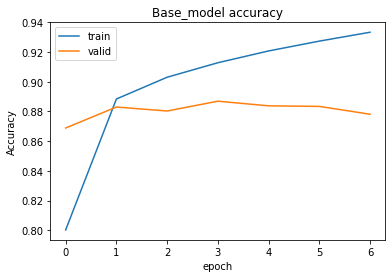

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Base_model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = Base_model.evaluate(X_test, y_test)

1361/1361 [==============================] - 6s 5ms/step - loss: 0.4377 - accuracy: 0.8815


Train accuracy increased substaintially after the first epoch and widenned the gap between train and validation accuracy. The model eventually (early) stop to avoid overfitting as val_accuracy did not improved. In the next trial, we will stack another transformer block to see if there any improvement in the score

4-4 Model 1 ( 2 Transformer Blocks)

In [ ]:
# adding a transformer block 

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

transformer_block1 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block1(x)

# Add another TransformerBlock
transformer_block2 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block2(x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model_1 = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the early stopping and checkpoint callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/model1_checkpoint.h5', save_best_only=True, monitor='val_loss', mode='min')

# Compile the model with the optimizer, loss function, and metrics
model_1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Define the CSV logger callback
csv_logger = keras.callbacks.CSVLogger('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/training_history1.csv')

# Fit the model with early stopping and checkpoint callbacks
history = model_1.fit(X_train, y_train, batch_size=32, epochs=10, 
                      validation_data=(X_valid, y_valid),
                      callbacks=[csv_logger, early_stop, checkpoint])

Epoch 1/10
4353/4353 [==============================] - 97s 21ms/step - loss: 0.5037 - accuracy: 0.8112 - val_loss: 0.3624 - val_accuracy: 0.8769
Epoch 2/10
4353/4353 [==============================] - 67s 15ms/step - loss: 0.3278 - accuracy: 0.8914 - val_loss: 0.3716 - val_accuracy: 0.8750
Epoch 3/10
4353/4353 [==============================] - 60s 14ms/step - loss: 0.2863 - accuracy: 0.9062 - val_loss: 0.4331 - val_accuracy: 0.8267
Epoch 4/10
4353/4353 [==============================] - 62s 14ms/step - loss: 0.2602 - accuracy: 0.9160 - val_loss: 0.3479 - val_accuracy: 0.8901
Epoch 5/10
4353/4353 [==============================] - 60s 14ms/step - loss: 0.2375 - accuracy: 0.9229 - val_loss: 0.3514 - val_accuracy: 0.8874
Epoch 6/10
4353/4353 [==============================] - 60s 14ms/step - loss: 0.2181 - accuracy: 0.9294 - val_loss: 0.3605 - val_accuracy: 0.8873
Epoch 7/10
4353/4353 [==============================] - 60s 14ms/step - loss: 0.1975 - accuracy: 0.9357 - val_loss: 0.3933 -

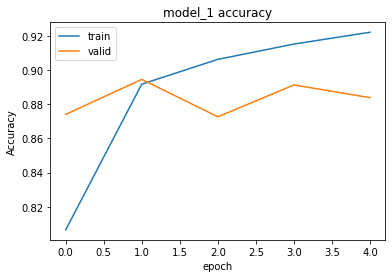

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = model_1.evaluate(X_test, y_test)

1361/1361 [==============================] - 9s 7ms/step - loss: 0.3544 - accuracy: 0.8878


With multiple Transforme Block, the model increase its capability to capture more complex sequence. The val_accuracy slightly better and also reached a peak of (0.89).  The model again stopped before the 10th epochs. We will continue the process by stacking another Transformer block

4-5 Model 2- (3 Transformer Blocks)

In [24]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

transformer_block1 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block1(x)

# Add another TransformerBlock
transformer_block2 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block2(x)

# Add another TransformerBlock
transformer_block3 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block3(x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model_2 = keras.Model(inputs=inputs, outputs=outputs)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the early stopping and checkpoint callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/model2_checkpoint.h5', save_best_only=True, monitor='val_loss', mode='min')

# Compile the model with the optimizer, loss function, and metrics
model_2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Define the CSV logger callback
csv_logger = keras.callbacks.CSVLogger('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/training_history2.csv')

# Fit the model with early stopping and checkpoint callbacks
history = model_2.fit(X_train, y_train, batch_size=32, epochs=10, 
                      validation_data=(X_valid, y_valid),
                      callbacks=[csv_logger, early_stop, checkpoint])

Epoch 1/10
4353/4353 [==============================] - 148s 31ms/step - loss: 0.5015 - accuracy: 0.8120 - val_loss: 0.4594 - val_accuracy: 0.8194
Epoch 2/10
4353/4353 [==============================] - 110s 25ms/step - loss: 0.3354 - accuracy: 0.8910 - val_loss: 0.3463 - val_accuracy: 0.8920
Epoch 3/10
4353/4353 [==============================] - 109s 25ms/step - loss: 0.2974 - accuracy: 0.9040 - val_loss: 0.3333 - val_accuracy: 0.8936
Epoch 4/10
4353/4353 [==============================] - 93s 21ms/step - loss: 0.2730 - accuracy: 0.9136 - val_loss: 0.3203 - val_accuracy: 0.8967
Epoch 5/10
4353/4353 [==============================] - 100s 23ms/step - loss: 0.2547 - accuracy: 0.9189 - val_loss: 0.3652 - val_accuracy: 0.8877
Epoch 6/10
4353/4353 [==============================] - 119s 27ms/step - loss: 0.2374 - accuracy: 0.9241 - val_loss: 0.3552 - val_accuracy: 0.8910
Epoch 7/10
4353/4353 [==============================] - 97s 22ms/step - loss: 0.2156 - accuracy: 0.9311 - val_loss: 0.3

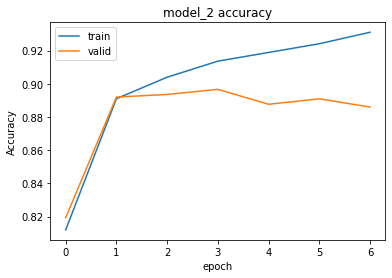

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = model_2.evaluate(X_test, y_test)

1361/1361 [==============================] - 10s 7ms/step - loss: 0.4740 - accuracy: 0.8766


No significant improvement in val_accuracy in the model 2 with 3 Transformer blocks, however the test_accuracy slightly decreased. To avoid over complicating our model, we decided to moved forward with 2 Tranformer blocks and perform randomsearch tuner in the next step

4-6 Keras Randomsearch Tunner

In this section, after defining train,test and valid dataset, we import keras_tuner and write a function that builds, compiles and returns a keras model.The function must take a kt.HyperParameters object as an argument,in which hyperparameters are defined with their range of possible values. The hyperparameter values are randomply pick to build and compile the model. The combination of hyperparameter values, that provide the highest accurarcy score for model, is then selected to create the best model.
 For our project, the following hyperparameters are selected for fine tunning:
 * **embed_dim**: embedding size for each token
 * **num_heads**: number of attention head
 * **ff_dim**: hidden layer size in feed forward network
 
We will run 'build model' function with 5 trial for our dataset. For each trial, this function pick a random value of the predefined range for each hyperparameter and after running 5 different architecture with different set of hyperparameters, the best model is selected based on val_accuracy score.

In [33]:
from keras.utils import to_categorical

# One-hot encode the target data
y_train_encoded = to_categorical(y_train, num_classes=3)
y_valid_encoded = to_categorical(y_valid, num_classes=3)

In [ ]:
!pip install keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.5 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Define the model architecture
def build_model(hp):
    embed_dim = hp.Int('embed_dim', min_value=16, max_value=64, step=16)
    num_heads = hp.Int('num_heads', min_value=2, max_value=4, step=1)
    ff_dim = hp.Int('ff_dim', min_value=16, max_value=64, step=16)
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    transformer_block2 = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block2(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(3, activation="softmax")(x)
    model_Random = keras.Model(inputs=inputs, outputs=outputs)
    model_Random.compile(optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', values=[1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model_Random

# Instantiate the tuner and perform the random search
random_search_tuner = RandomSearch(build_model, objective="val_accuracy", max_trials=5, overwrite=True,
directory="GPT", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train_encoded, epochs=5, validation_data=(X_valid, y_valid_encoded),callbacks=[keras.callbacks.EarlyStopping(patience=3)])

Trial 5 Complete [00h 08m 27s]
val_accuracy: 0.8867892026901245

Best val_accuracy So Far: 0.8919586539268494
Total elapsed time: 00h 36m 34s


In [ ]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [ ]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial summary
Hyperparameters:
embed_dim: 48
num_heads: 2
ff_dim: 32
learning_rate: 0.001
Score: 0.8919586539268494


Here we have all the best hyper parameters value after the tunning, we will save the best model and continue to run for more epochs

In [ ]:
best_model.save('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/best_tuner_model.h5')

In [28]:
from keras.models import load_model
from keras.utils import custom_object_scope

In [29]:
with custom_object_scope({'TokenAndPositionEmbedding': TokenAndPositionEmbedding,'TransformerBlock':TransformerBlock}):
    loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/best_tuner_model.h5')

In [30]:
# Define the early stopping and checkpoint callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/best_tuner_01.h5', save_best_only=True, monitor='val_loss', mode='min')

# Compile the model with the optimizer, loss function, and metrics
loaded_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Define the CSV logger callback
csv_logger = keras.callbacks.CSVLogger('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/training_history_best_tuner.csv')

# Fit the model with early stopping and checkpoint callbacks
history = loaded_model.fit(X_train, y_train, batch_size=32, epochs=20, 
                      validation_data=(X_valid, y_valid),
                      callbacks=[csv_logger, early_stop, checkpoint])

Epoch 1/20
4353/4353 [==============================] - 119s 25ms/step - loss: 0.2928 - accuracy: 0.9041 - val_loss: 0.3393 - val_accuracy: 0.8884
Epoch 2/20
4353/4353 [==============================] - 89s 20ms/step - loss: 0.2643 - accuracy: 0.9146 - val_loss: 0.3602 - val_accuracy: 0.8826
Epoch 3/20
4353/4353 [==============================] - 82s 19ms/step - loss: 0.2403 - accuracy: 0.9218 - val_loss: 0.3655 - val_accuracy: 0.8861
Epoch 4/20
4353/4353 [==============================] - 81s 19ms/step - loss: 0.2150 - accuracy: 0.9303 - val_loss: 0.3691 - val_accuracy: 0.8851
Epoch 4: early stopping


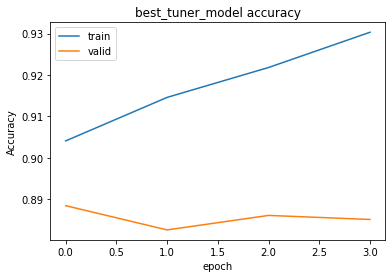

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('best_tuner_model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

The model quickly stopped after only 4 epochs as the val_accuracy did not improve. A similar accuracy score is obtained in comparision with the manual fine tunning result. After different trials on the Block Transfer layer with no significant improvement, we moved to fine tuning the Head layer.

In [35]:
# y_test_encoded = to_categorical(y_test, num_classes=3)


In [39]:
# test_loss, test_acc = loaded_model.evaluate(X_test, y_test_encoded)

4-7 Fine-tunning Head layer

Dropping number of nodes in the Dense layer for less complexity

In [ ]:
#dropping the nodes from 20 to 10

In [44]:
embed_dim = 48  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

transformer_block1 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block1(x)

# Add another TransformerBlock
transformer_block2 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block2(x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(10, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model_3 = keras.Model(inputs=inputs, outputs=outputs)

In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the early stopping and checkpoint callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/model3_head_layer_checkpoint.h5', save_best_only=True, monitor='val_loss', mode='min')

# Compile the model with the optimizer, loss function, and metrics
optimizer = Adam(learning_rate=0.001)
model_3.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Define the CSV logger callback
csv_logger = keras.callbacks.CSVLogger('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/training_history3.csv')

# Fit the model with early stopping and checkpoint callbacks
history = model_3.fit(X_train, y_train, batch_size=32, epochs=10, 
                      validation_data=(X_valid, y_valid),
                      callbacks=[csv_logger, early_stop, checkpoint])

Epoch 1/10
4353/4353 [==============================] - 111s 24ms/step - loss: 0.5770 - accuracy: 0.7718 - val_loss: 0.3960 - val_accuracy: 0.8599
Epoch 2/10
4353/4353 [==============================] - 76s 18ms/step - loss: 0.3721 - accuracy: 0.8707 - val_loss: 0.3624 - val_accuracy: 0.8704
Epoch 3/10
4353/4353 [==============================] - 78s 18ms/step - loss: 0.3191 - accuracy: 0.8917 - val_loss: 0.3382 - val_accuracy: 0.8848
Epoch 4/10
4353/4353 [==============================] - 82s 19ms/step - loss: 0.2848 - accuracy: 0.9043 - val_loss: 0.3442 - val_accuracy: 0.8862
Epoch 5/10
4353/4353 [==============================] - 83s 19ms/step - loss: 0.2544 - accuracy: 0.9150 - val_loss: 0.3740 - val_accuracy: 0.8791
Epoch 6/10
4353/4353 [==============================] - 74s 17ms/step - loss: 0.2321 - accuracy: 0.9218 - val_loss: 0.3819 - val_accuracy: 0.8775
Epoch 7/10
4353/4353 [==============================] - 80s 18ms/step - loss: 0.2095 - accuracy: 0.9295 - val_loss: 0.3964 

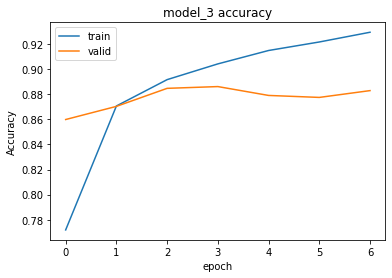

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = model_3.evaluate(X_test, y_test)

1361/1361 [==============================] - 9s 7ms/step - loss: 0.3923 - accuracy: 0.8850


Adding another layer for more complexity

In [47]:
embed_dim = 48  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

transformer_block1 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block1(x)

# Add another TransformerBlock
transformer_block2 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block2(x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(10, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model_4 = keras.Model(inputs=inputs, outputs=outputs)

In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the early stopping and checkpoint callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/model4_head_layer_checkpoint.h5', save_best_only=True, monitor='val_loss', mode='min')

# Compile the model with the optimizer, loss function, and metrics
optimizer = Adam(learning_rate=0.001)
model_4.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Define the CSV logger callback
csv_logger = keras.callbacks.CSVLogger('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/training_history4.csv')

# Fit the model with early stopping and checkpoint callbacks
history = model_4.fit(X_train, y_train, batch_size=32, epochs=10, 
                      validation_data=(X_valid, y_valid),
                      callbacks=[csv_logger, early_stop, checkpoint])

Epoch 1/10
4353/4353 [==============================] - 110s 23ms/step - loss: 0.6050 - accuracy: 0.7656 - val_loss: 0.4132 - val_accuracy: 0.8551
Epoch 2/10
4353/4353 [==============================] - 86s 20ms/step - loss: 0.3862 - accuracy: 0.8692 - val_loss: 0.3566 - val_accuracy: 0.8807
Epoch 3/10
4353/4353 [==============================] - 78s 18ms/step - loss: 0.3257 - accuracy: 0.8933 - val_loss: 0.3615 - val_accuracy: 0.8800
Epoch 4/10
4353/4353 [==============================] - 74s 17ms/step - loss: 0.2939 - accuracy: 0.9054 - val_loss: 0.3631 - val_accuracy: 0.8868
Epoch 5/10
4353/4353 [==============================] - 79s 18ms/step - loss: 0.2677 - accuracy: 0.9139 - val_loss: 0.3708 - val_accuracy: 0.8742
Epoch 6/10
4353/4353 [==============================] - 83s 19ms/step - loss: 0.2441 - accuracy: 0.9210 - val_loss: 0.3999 - val_accuracy: 0.8846
Epoch 7/10
4353/4353 [==============================] - 73s 17ms/step - loss: 0.2256 - accuracy: 0.9264 - val_loss: 0.3992 

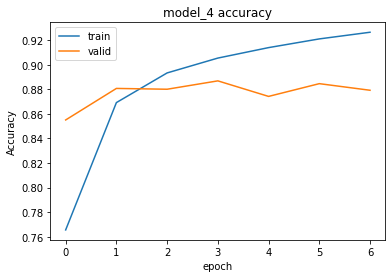

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_4 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = model_4.evaluate(X_test, y_test)

1361/1361 [==============================] - 9s 7ms/step - loss: 0.3953 - accuracy: 0.8785


After both trial with either increase or decrease the complexity of the Head layer, similar results are obtained in both cases with no further improvement. We will move to different architecture by changing the Transformer Block from self-attention to causal attention

4-8 Causal Attention

In [37]:
class CasualTransformerBlockCausal(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1,**kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, attention_axes=(1,)
        )  # set attention_axes to (1,) to apply causal mask
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        causal_mask = self.create_causal_mask(inputs)  # create causal mask
        attn_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def create_causal_mask(self, inputs):
        seq_len = tf.shape(inputs)[1]
        mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return mask  # causal mask with shape (seq_len, seq_len)

In [38]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim,**kwargs):
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [40]:
embed_dim = 48  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

transformer_block1 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block1(x)

# Add another TransformerBlock
transformer_block2 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block2(x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model_causal = keras.Model(inputs=inputs, outputs=outputs)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the early stopping and checkpoint callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/model_causal_checkpoint.h5', save_best_only=True, monitor='val_loss', mode='min')

# Compile the model with the optimizer, loss function, and metrics
optimizer = Adam(learning_rate=0.001)
model_causal.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Define the CSV logger callback
csv_logger = keras.callbacks.CSVLogger('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/training_history_causal.csv')

# Fit the model with early stopping and checkpoint callbacks
history = model_causal.fit(X_train, y_train, batch_size=32, epochs=10, 
                      validation_data=(X_valid, y_valid),
                      callbacks=[csv_logger, early_stop, checkpoint])

Epoch 1/10
4353/4353 [==============================] - 106s 23ms/step - loss: 0.5673 - accuracy: 0.7797 - val_loss: 0.3931 - val_accuracy: 0.8590
Epoch 2/10
4353/4353 [==============================] - 84s 19ms/step - loss: 0.3544 - accuracy: 0.8777 - val_loss: 0.3431 - val_accuracy: 0.8835
Epoch 3/10
4353/4353 [==============================] - 71s 16ms/step - loss: 0.2990 - accuracy: 0.9002 - val_loss: 0.3584 - val_accuracy: 0.8769
Epoch 4/10
4353/4353 [==============================] - 90s 21ms/step - loss: 0.2637 - accuracy: 0.9127 - val_loss: 0.3696 - val_accuracy: 0.8829
Epoch 5/10
4353/4353 [==============================] - 75s 17ms/step - loss: 0.2365 - accuracy: 0.9217 - val_loss: 0.3553 - val_accuracy: 0.8848
Epoch 6/10
4353/4353 [==============================] - 77s 18ms/step - loss: 0.2156 - accuracy: 0.9290 - val_loss: 0.4048 - val_accuracy: 0.8830
Epoch 7/10
4353/4353 [==============================] - 69s 16ms/step - loss: 0.1975 - accuracy: 0.9336 - val_loss: 0.4396 

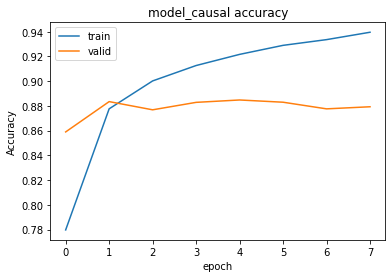

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_causal accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [43]:
test_loss, test_acc = model_causal.evaluate(X_test, y_test)

1361/1361 [==============================] - 11s 8ms/step - loss: 0.4484 - accuracy: 0.8807


Causal attention only attend to prior positions in the sequence instead of all different positions like the case self-attention, which is more suitable for the problems like text or speech generation. However, here in the result, both of causal and self attention produced the similar result over the text classification problem.

After multiple trials with different approachs, we received the similar results with val_accuracy in the range of [0.87, 0.89]. To validate our thought on where the using Transformer as a good approach for the problem, we decided to also run it with a deep learning model with only fully connected layers

4-9 Deep Learning -Fully connected model 

In [65]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/Colab Notebooks/glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [66]:
embedding_matrix = zeros((20000, 50))
for word, index in tokenizer.word_index.items():
    if index < 20000:
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
      

In [67]:
model_D = Sequential()
embedding_layer = Embedding(20000, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)

model_D.add(embedding_layer)
model_D.add(Dense(128, activation='relu', kernel_initializer="he_normal" ))
model_D.add(Dense(64, activation='relu', kernel_initializer="he_normal" ))
model_D.add(Dense(32, activation='relu', kernel_initializer="he_normal" ))
model_D.add(Dense(16, activation='relu', kernel_initializer="he_normal" ))
model_D.add(Dense(8, activation='relu', kernel_initializer="he_normal" ))
model_D.add(Flatten())
model_D.add(Dense(3, activation='softmax'))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_D.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [68]:
# Define the early stopping and checkpoint callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/model_deeplearning_checkpoint.h5', save_best_only=True, monitor='val_loss', mode='min')

In [69]:
# Define the CSV logger callback
csv_logger = keras.callbacks.CSVLogger('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/training_history_deepleanring.csv')

In [70]:
history = model_D.fit(X_train, y_train, validation_split=0.2, batch_size = 32, epochs = 50)

Epoch 1/50
3482/3482 [==============================] - 26s 7ms/step - loss: 1.0055 - accuracy: 0.5138 - val_loss: 0.9671 - val_accuracy: 0.5430
Epoch 2/50
3482/3482 [==============================] - 24s 7ms/step - loss: 0.9540 - accuracy: 0.5489 - val_loss: 0.9425 - val_accuracy: 0.5555
Epoch 3/50
3482/3482 [==============================] - 24s 7ms/step - loss: 0.9259 - accuracy: 0.5639 - val_loss: 0.9073 - val_accuracy: 0.5743
Epoch 4/50
3482/3482 [==============================] - 26s 7ms/step - loss: 0.8873 - accuracy: 0.5851 - val_loss: 0.8658 - val_accuracy: 0.5969
Epoch 5/50
3482/3482 [==============================] - 26s 8ms/step - loss: 0.8470 - accuracy: 0.6103 - val_loss: 0.8252 - val_accuracy: 0.6231
Epoch 6/50
3482/3482 [==============================] - 25s 7ms/step - loss: 0.8114 - accuracy: 0.6322 - val_loss: 0.7947 - val_accuracy: 0.6460
Epoch 7/50
3482/3482 [==============================] - 25s 7ms/step - loss: 0.7842 - accuracy: 0.6510 - val_loss: 0.7735 - val_ac

In [71]:
test_loss, test_acc = model_D.evaluate(X_test, y_test)

1361/1361 [==============================] - 8s 6ms/step - loss: 0.5532 - accuracy: 0.8129


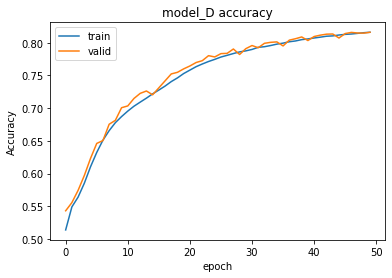

In [72]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_D accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

Apparently, the accuracy score in the "Full connected" model is lower than the Transformer model, which reflects the better capability of Transformer model in capturing the complex pattern and produce high quality output. 

# 5- Evaluation

In [74]:
df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MathDL2/Project1_model/combined_result.csv')
summary = df.groupby('Model')[['accuracy','val_accuracy']].mean()

In [79]:
print(summary.sort_values('val_accuracy', ascending =False))

            accuracy  val_accuracy
Model                             
Best_tuner  0.917701      0.885540
Model 2     0.899248      0.880898
Base        0.897984      0.880615
Causual     0.899277      0.878367
Model 3     0.886403      0.877271
Model 4     0.884965      0.877234
Model 1     0.901839      0.874662
Model 5     0.898134      0.872813


In conclusion, we have built and examined our Transformer model by increasing level of complexity, changing alogrithm, performing fine-tuning with random search. Even though after multiple trials, we were unable to increase the accuracy score. The project has provided a great understanding of Transformer model in solving NLP task and practice our coding skill in building model from the scratch.  

One of the problems we observed is that the validation accuracy quickly dropped after only a few epochs. It also shown that the model poorly performed on unseen data. This can link back to the limitation of our data input.In our Project 2, we will continue with this problem but making use of pre-trained models (i.e BERT, GPTs...) for further improvement.